# 🧩 Notebook 10: Posthoc Tests & Advanced Inference

In [1]:
# Setup and Imports

import pandas as pd
import numpy as np
from pathlib import Path
import sys

# ✅ Setup path to use utils
PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Imports
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg

from utils.visual_utils import save_and_show_plot
from utils.model_utils import export_model_summary_as_text, compute_hotelling_t2


In [2]:
# Paths
DATA_PATH = Path("../synthetic_data")
EXPORT_PLOTS = Path("../exports/plots/10_posthoc_advanced")
EXPORT_TABLES = Path("../exports/tables/10_posthoc_advanced")
EXPORT_PLOTS.mkdir(parents=True, exist_ok=True)
EXPORT_TABLES.mkdir(parents=True, exist_ok=True)

## 🔹 Step 1: Load and extend MANOVA dataset

In [3]:
# Load Dataset
df = pd.read_csv(DATA_PATH / "manova_data.csv")
df.head()

,Y1,Y2,group
0,0.038227,0.250106,A
1,0.277570,1.273579,A
2,-0.287370,-0.212594,A
3,-0.972675,-1.092789,A
4,0.400296,-0.084333,A


## 🔹 Step 2: Tukey’s HSD for each response separately

In [4]:
# Turkey's HSD for each reponse separately
tukey_y1 = pairwise_tukeyhsd(endog=df["Y1"], groups=df["group"], alpha=0.05)
print(tukey_y1.summary())
with open(EXPORT_TABLES / "tukey_y1.txt", "w") as f:
    f.write(str(tukey_y1.summary()))

tukey_y2 = pairwise_tukeyhsd(endog=df["Y2"], groups=df["group"], alpha=0.05)
with open(EXPORT_TABLES / "tukey_y2.txt", "w") as f:
    f.write(str(tukey_y2.summary()))

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
     A      B   1.7055   0.0 1.4807 1.9303   True
-------------------------------------------------


## 🔹 Step 3: Pairwise t-tests with Bonferroni and Holm correction

In [5]:
# Pairwise t-tests with Bonferroni and Holm correction
res_y1 = pg.pairwise_ttests(dv="Y1", between="group", data=df, padjust="holm")
res_y2 = pg.pairwise_ttests(dv="Y2", between="group", data=df, padjust="bonf")

res_y1.to_csv(EXPORT_TABLES / "pairwise_y1_holm.csv", index=False)
res_y2.to_csv(EXPORT_TABLES / "pairwise_y2_bonferroni.csv", index=False)

/Users/satvikpraveen/Desktop/Libraries/StatsmodelsMasterPro/sm_env/lib/python3.11/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)
/Users/satvikpraveen/Desktop/Libraries/StatsmodelsMasterPro/sm_env/lib/python3.11/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


/var/folders/23/phyj43kx4jz5gywlx6__9_kc0000gn/T/ipykernel_35670/4190426940.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x=x_col, y=y_col, palette="Set2")


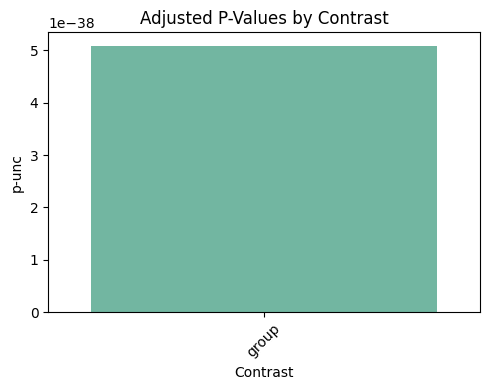

In [6]:
# plot of p-values
def plot_adjusted_pvals(df, x_col="Contrast", y_col="p-unc", filename="adjusted_pvals"):
    plt.figure(figsize=(5, 4))
    sns.barplot(data=df, x=x_col, y=y_col, palette="Set2")
    plt.title("Adjusted P-Values by Contrast")
    plt.xticks(rotation=45)
    save_and_show_plot(filename, EXPORT_PLOTS)


# Plot - residuals for y1
plot_adjusted_pvals(res_y1, "Contrast", "p-unc", "adjusted_pvals_y1")

/var/folders/23/phyj43kx4jz5gywlx6__9_kc0000gn/T/ipykernel_35670/4190426940.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x=x_col, y=y_col, palette="Set2")


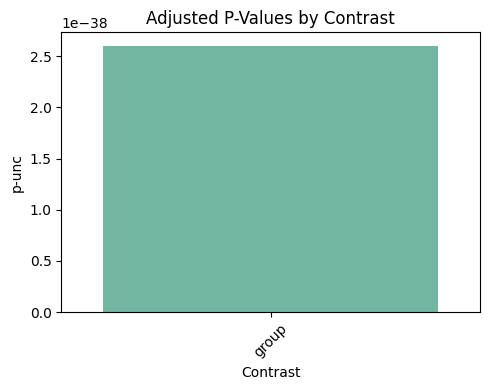

In [7]:
# Plot - residuals for y2
plot_adjusted_pvals(res_y2, x_col="Contrast", y_col="p-unc", filename="adjusted_pvals_y2")

## 🔹 Step 4: Hotelling’s T² Test (Multivariate)

In [8]:
# Hotelling’s T² Test (Multivariate)
group1 = df[df['group'] == 'A']
group2 = df[df['group'] == 'B']
cols = ['Y1', 'Y2']

hotelling_result = compute_hotelling_t2(group1, group2, cols)
hotelling_df = pd.DataFrame([hotelling_result])
display(hotelling_df)

# Export to CSV
hotelling_df.to_csv(EXPORT_TABLES / "hotellings_t2_manual.csv", index=False)

,T2,F,p_value
0,290.174496,144.600378,1.110223e-16


## ✅ Summary:
- Compared `Y1`, `Y2` between group A & B using:
    - Tukey's HSD
    - Bonferroni & Holm-corrected pairwise t-tests
    - Hotelling's T² multivariate test
- Exported all summaries, results, and visualizations